# NLLS fitting with LMFIT

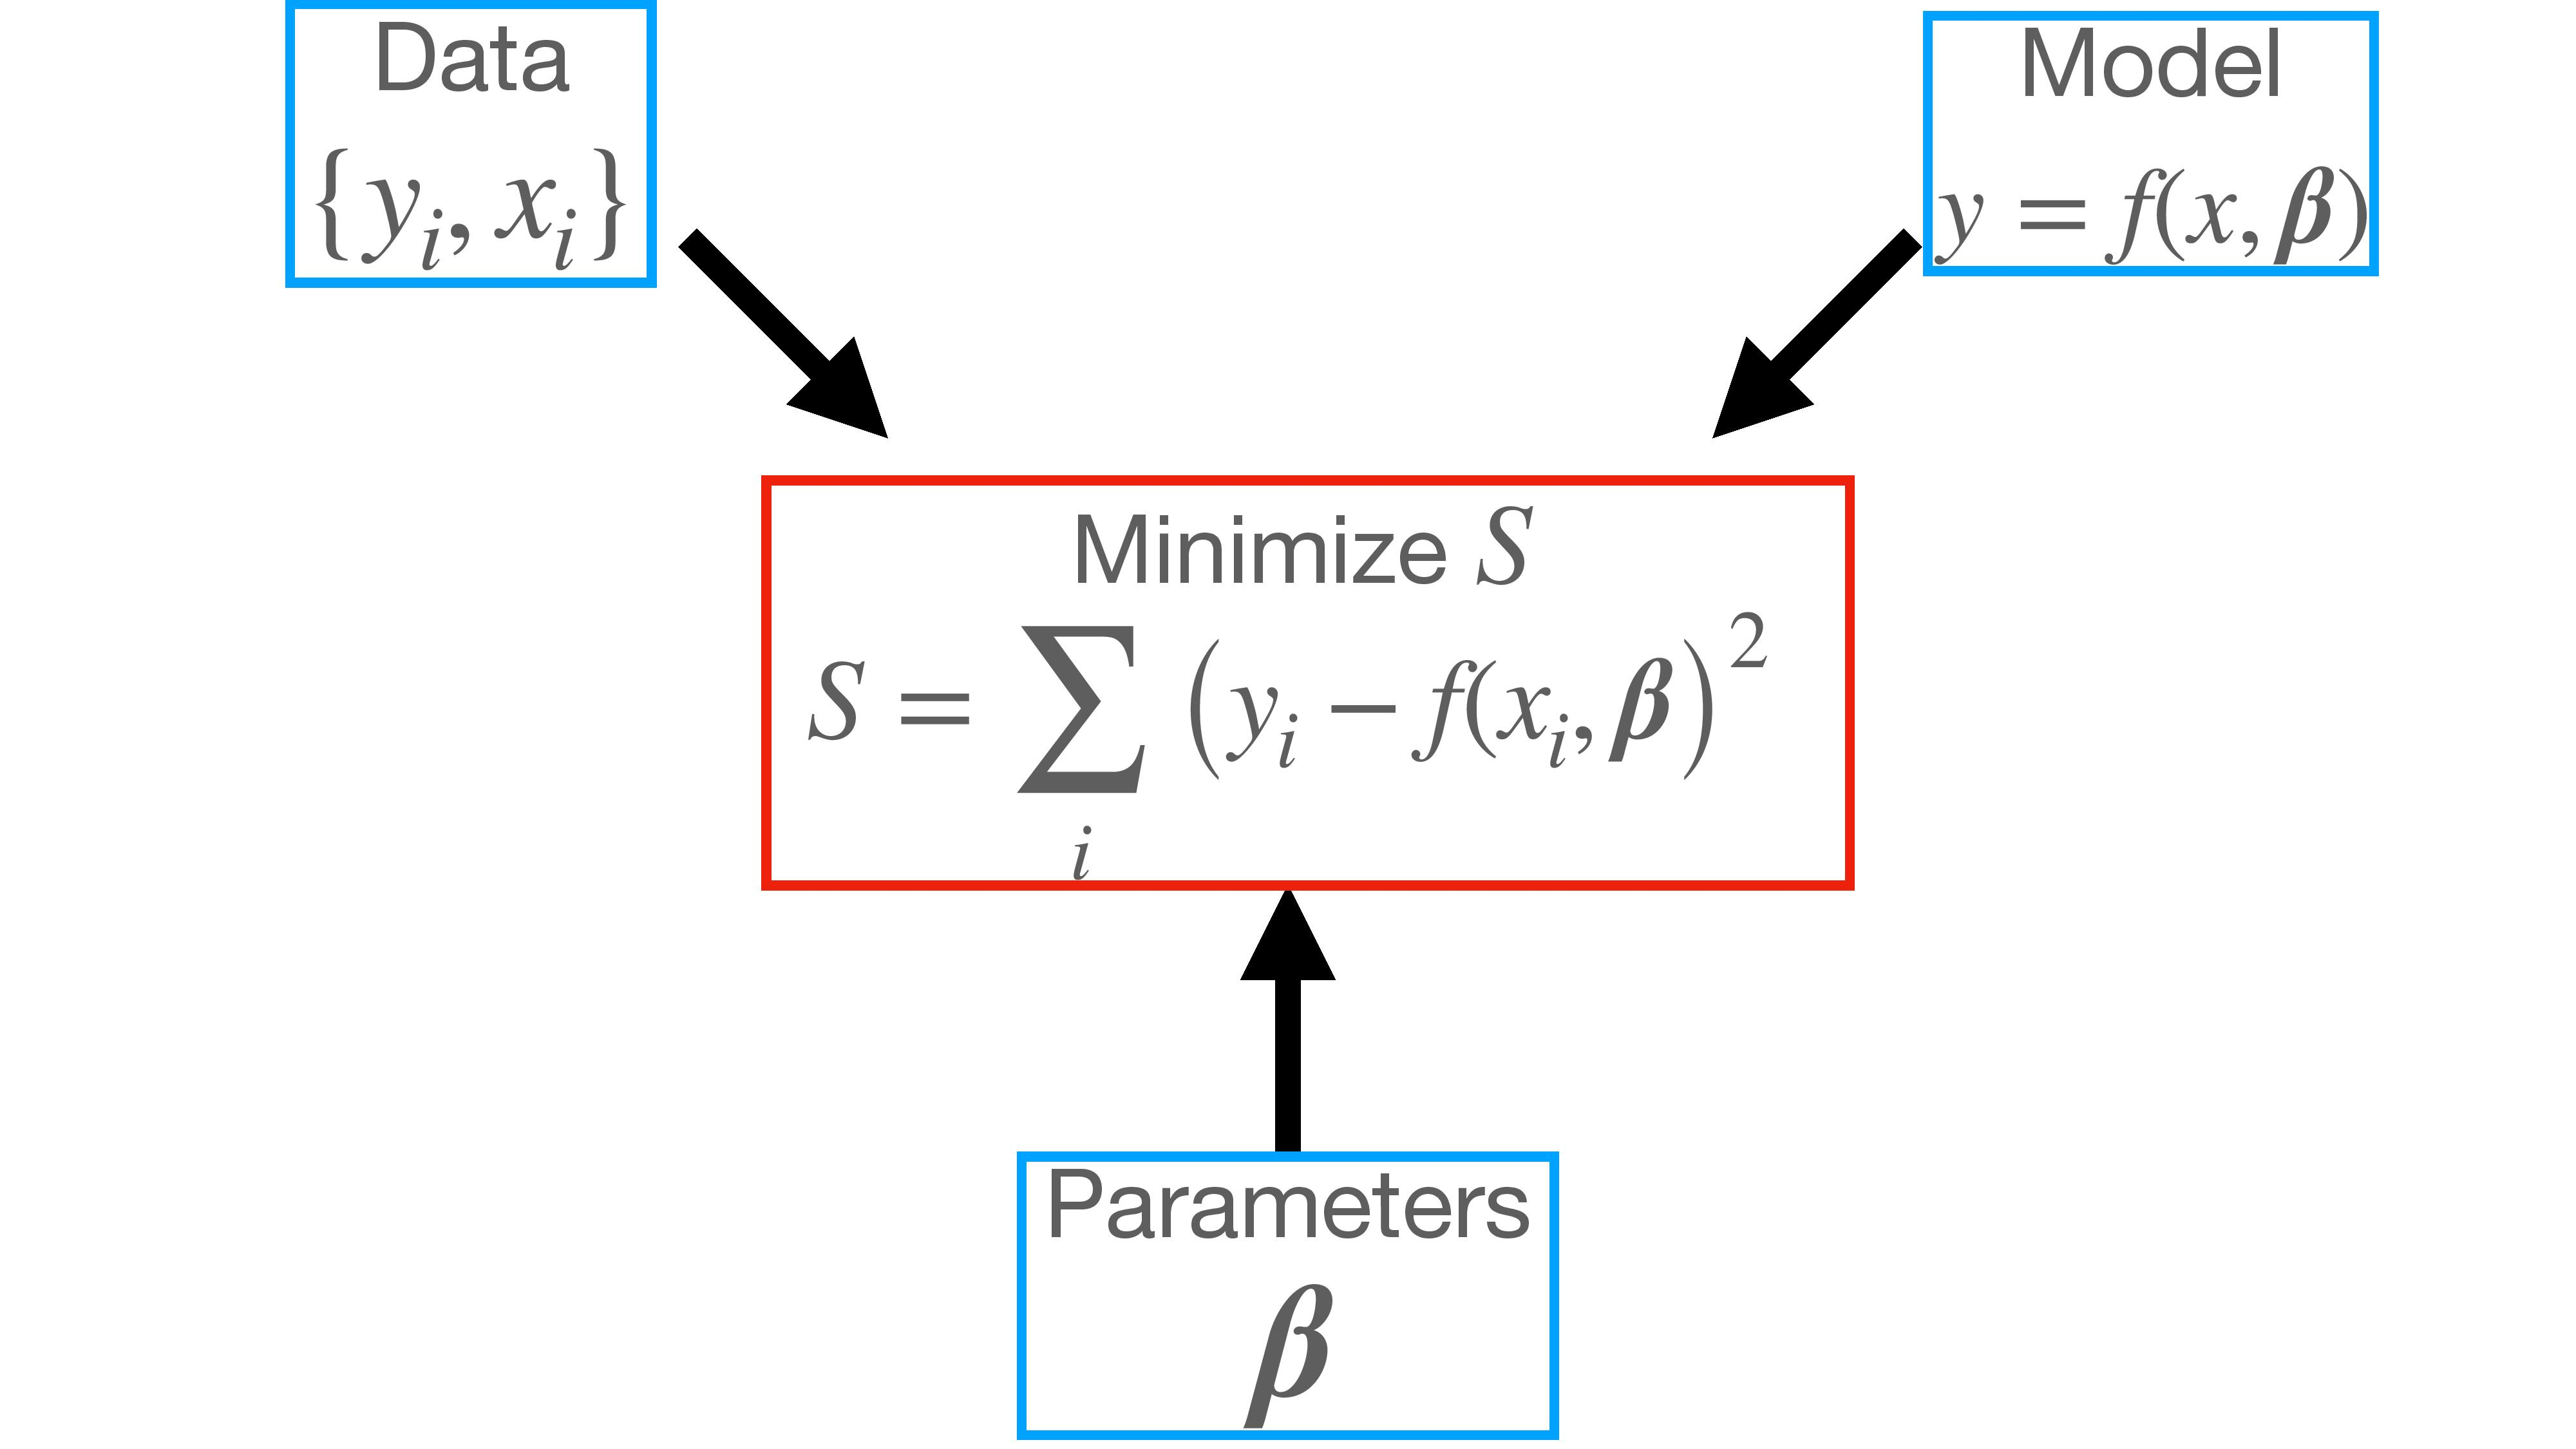

In [1]:
from lmfit import Minimizer, Parameters, report_fit
import numpy as np
import matplotlib.pylab as plt

In [2]:
t = np.arange(0, 24, 2)
N = np.array([32500, 33000, 38000, 105000, 445000, 1430000, 3020000, 4720000, 5670000, 5870000, 5930000, 5940000])

In [3]:
np.random.seed(1234)

In [4]:
#Add some error to data
N_rand = N*(1 + np.random.normal(scale = 0.1, size = len(N)))

## Linear model fit

Lets start with the simplest case; a linear model. 

\begin{equation*}\label{eq:linear_model}
    N_t = at^3 + bt^2 + ct + d
\end{equation*} 

where $a$, $b$, $c$ and $d$, are phenomenological parameters.

In [5]:
#Create object for parameter storing
params_linear = Parameters()
params_linear.add('a', value = 1)
params_linear.add('b', value = 1)
params_linear.add('c', value = 1)
params_linear.add('d', value = 1)

In [6]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_linear(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = np.log(v['a']*t**3 + v['b']*t**2 + v['c']*t + v['d'])
    #Return residuals
    return model - data

In [7]:
#Create a Minimizer object
minner = Minimizer(residuals_linear, params_linear, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_linear = minner.minimize()

The variable `fit_linear` belongs to a class called [`MinimizerResult`](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult), which include data such as status and error messages, fit statistics, and the updated (i.e., best-fit) parameters themselves in the params attribute. 

In [8]:
#Get summary of the fit
report_fit(fit_linear)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 12
    # variables        = 4
    chi-square         = 1.77359807
    reduced chi-square = 0.22169976
    Akaike info crit   = -14.9427563
    Bayesian info crit = -13.0031297
[[Variables]]
    a:  1399.67837 +/- 428.604075 (30.62%) (init = 1)
    b: -4920.54491 +/- 5670.56003 (115.24%) (init = 1)
    c: -930.313709 +/- 18383.6763 (1976.07%) (init = 1)
    d:  36551.6498 +/- 16988.2632 (46.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = -0.911
    C(a, b) = -0.905
    C(a, c) =  0.719
    C(c, d) = -0.680
    C(b, d) =  0.424
    C(a, d) = -0.263


## Logistic model fit

A classical, somewhat mechanistic model is the logistic equation:

\begin{equation*}
    N_t =   \frac{N_0  N_{max} e^{r t}}{N_{max} + N_0 (e^{r t} - 1)}
\end{equation*}

Here $N_t$ is population size at time $t$, $N_0$ is initial population size, $r$ is maximum growth rate (AKA $r_{max}$), and $N_{max}$ is carrying capacity (commonly denoted by $K$ in the ecological literature).

In [9]:
#Create object for parameter storing
params_logistic = Parameters()
params_logistic.add('N_0', value = N_rand[0])
params_logistic.add('N_max', value = N_rand[-1])
#Recall the value for growth rate obtained from a linear fit
params_logistic.add('r', value = 0.62)

In [10]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_logistic(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = np.log(v['N_0'] * v['N_max'] * np.exp(v['r']*t) / \
    (v['N_max'] + v['N_0'] * ( np.exp(v['r']*t) - 1 )))
    #Return residuals
    return model - data

In [11]:
#Create a Minimizer object
minner = Minimizer(residuals_logistic, params_logistic, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_logistic = minner.minimize()

In [12]:
#Get summary of the fit
report_fit(fit_logistic)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 12
    # variables        = 3
    chi-square         = 2.19693074
    reduced chi-square = 0.24410342
    Akaike info crit   = -14.3741446
    Bayesian info crit = -12.9194246
[[Variables]]
    N_0:    13998.5739 +/- 4769.60185 (34.07%) (init = 34032.16)
    N_max:  7108406.32 +/- 2165947.53 (30.47%) (init = 6529216)
    r:      0.44848151 +/- 0.05161938 (11.51%) (init = 0.62)
[[Correlations]] (unreported correlations are < 0.100)
    C(N_0, r)     = -0.807
    C(N_max, r)   = -0.448
    C(N_0, N_max) =  0.239


## Gompertz model fit

Another alternative is the Gompertz model, which has been used frequently in the literature to model bacterial growth

\begin{equation*}\label{eq:Gompertzlog}
     \log(N_t) =  N_0 + (N_{max} - N_0) e^{-e^{r_{max} \exp(1) \frac{t_{lag} - t}{(N_{max} - N_0) \log(10)} + 1}}
\end{equation*}

Here maximum growth rate ($r_{max}$) is the tangent to the inflection point, $t_{lag}$ is the x-axis intercept to this tangent (duration of the delay before the population starts growing exponentially) and $\log\left(\frac{N_{max}}{N_0}\right)$ is the asymptote of the log-transformed population growth trajectory, i.e., the log ratio of maximum population density $N_{max}$ (aka “carrying capacity”) and initial cell (Population) $N_0$ density.

In [13]:
#Create object for parameter storing
params_gompertz = Parameters()
# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
params_gompertz.add_many(('N_0', np.log(N_rand)[0] , True, None, None, None, None),
                         ('N_max', np.log(N_rand)[-1], True, None, None, None, None),
                         ('r_max', 0.62, True, None, None, None, None),
                         ('t_lag', 5, True, 0, None, None, None))#I see it in the graph


In [14]:
#Write down the objective function that we want to minimize, i.e., the residuals 
def residuals_gompertz(params, t, data):
    '''Model a logistic growth and subtract data'''
    #Get an ordered dictionary of parameter values
    v = params.valuesdict()
    #Logistic model
    model = v['N_0'] + (v['N_max'] - v['N_0']) * \
    np.exp(-np.exp(v['r_max'] * np.exp(1) * (v['t_lag'] - t) / \
                   ((v['N_max'] - v['N_0']) * np.log(10)) + 1))
    #Return residuals
    return model - data

In [15]:
#Create a Minimizer object
minner = Minimizer(residuals_gompertz, params_gompertz, fcn_args=(t, np.log(N_rand)))
#Perform the minimization
fit_gompertz = minner.minimize()

In [16]:
#Sumarize results
report_fit(fit_gompertz)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 12
    # variables        = 4
    chi-square         = 0.11350314
    reduced chi-square = 0.01418789
    Akaike info crit   = -47.9299775
    Bayesian info crit = -45.9903509
[[Variables]]
    N_0:    10.3910132 +/- 0.07901004 (0.76%) (init = 10.43506)
    N_max:  15.6520240 +/- 0.06730934 (0.43%) (init = 15.6918)
    r_max:  1.74097656 +/- 0.09837837 (5.65%) (init = 0.62)
    t_lag:  4.52049062 +/- 0.24729702 (5.47%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_max, t_lag) =  0.757
    C(N_0, t_lag)   =  0.581
    C(N_max, r_max) = -0.465
    C(N_max, t_lag) = -0.318
    C(N_0, N_max)   = -0.132
    C(N_0, r_max)   =  0.115


## Plot results

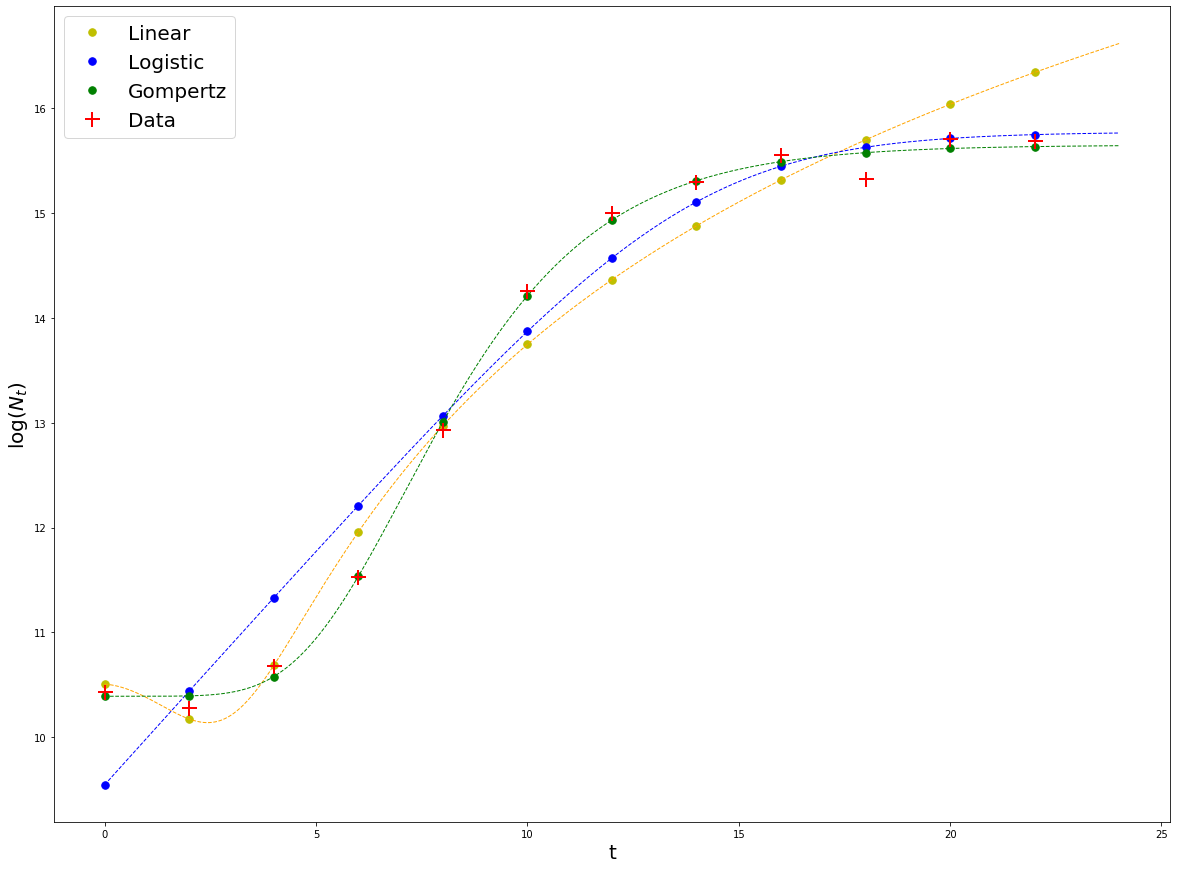

In [17]:
plt.rcParams['figure.figsize'] = [20, 15]
#Linear
result_linear = np.log(N_rand) + fit_linear.residual
plt.plot(t, result_linear, 'y.', markersize = 15, label = 'Linear')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_linear = residuals_linear(fit_linear.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_linear + log_N_vec, 'orange', linestyle = '--', linewidth = 1)

#Logistic
result_logistic = np.log(N_rand) + fit_logistic.residual
plt.plot(t, result_logistic, 'b.', markersize = 15, label = 'Logistic')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_logistic = residuals_logistic(fit_logistic.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_logistic + log_N_vec, 'blue', linestyle = '--', linewidth = 1)

#Gompertz
result_gompertz = np.log(N_rand) + fit_gompertz.residual
plt.plot(t, result_gompertz, 'g.', markersize = 15, label = 'Gompertz')
#Get a smooth curve by plugging a time vector to the fitted logistic model
t_vec = np.linspace(0,24,1000)
log_N_vec = np.ones(len(t_vec))
residual_smooth_gompertz = residuals_gompertz(fit_gompertz.params, t_vec, log_N_vec)
plt.plot(t_vec, residual_smooth_gompertz + log_N_vec, 'green', linestyle = '--', linewidth = 1)

#Plot data points
plt.plot(t, np.log(N_rand), 'r+', markersize = 15,markeredgewidth = 2, label = 'Data')

#Plot legend
plt.legend(fontsize = 20)
plt.xlabel('t', fontsize = 20)
plt.ylabel(r'$\log(N_t)$', fontsize = 20)
plt.ticklabel_format(style='scientific', scilimits=[0,3])